## Исследовательский анализ данных

Импортируем нужные библиотеки.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим данные:

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Глянем на общие данные:

In [ ]:
display(labels, labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


None

In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Видим сразу аномалии: min возраст 1 и мах 100. Глянем распределение на графике.

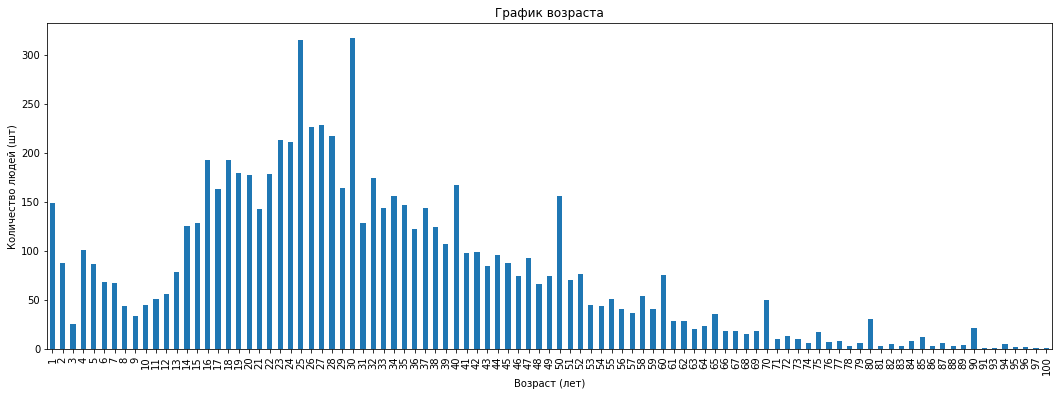

In [ ]:
age = labels.pivot_table(index='real_age',
                         aggfunc='count')
age.plot(kind='bar',
        title='График возраста',
        grid=False,
        figsize=(18, 6),
        legend=False).set(xlabel='Возраст (лет)',
                            ylabel='Количество людей (шт)')
plt.show()

Видим, что основная масса потребителя от 14 до 52 лет. 150 людей аномально имеют 1 год по возрасту. Видимо родители приходят в магазин, чтобы закупиться нужными вещами и они это делают с детьми, не могу оставить их дома. И чаще это делают люди с детьми до 10 лет. Так же мало пенсионеров, им лень или не могут выйти на улицу из-за возраста. Наблюдаем пики на круглых датах, это день рождения или юбилеи. Такая дата более значима чем просто день рождение и от сюда пики. А еще у нас данные смещены влево.

Глянем на фотографии в выборке.

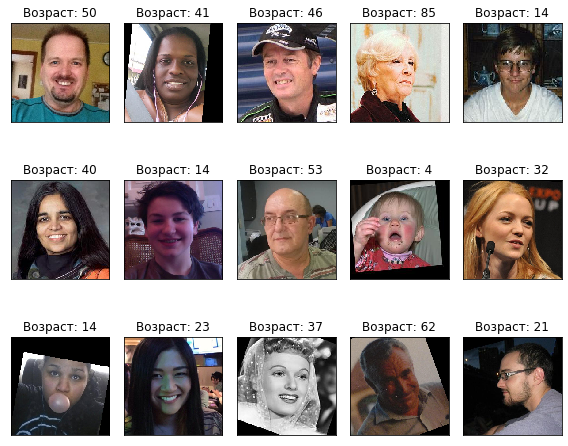

In [ ]:
features, target = next(train_gen_flow)
features.shape

fig = plt.figure(figsize=(8, 8))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Возраст: {target[i]}')
    plt.tight_layout()

Мы видим разные фото: цветные и черно-белые, нормальные и скошенные (использование аугментации).

## Обучение модели

```python
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import numpy as np

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow
    
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    val_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    val_datagen_flow = val_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return val_datagen_flow
    
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    optimizer = Adam(lr=0.0001)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss = 'mean_squared_error', metrics=['mae'])
    return model
    
def train_model(model, train_datagen_flow, val_datagen_flow, batch_size=None, epochs=15, steps_per_epoch=None, validation_steps=None):
    model.fit(train_datagen_flow,
              validation_data=val_datagen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/15
178/178 - 116s - loss: 228.1789 - mae: 10.8744 - val_loss: 858.0781 - val_mae: 24.4097
Epoch 2/15
178/178 - 37s - loss: 73.7381 - mae: 6.5059 - val_loss: 651.0394 - val_mae: 20.3655
Epoch 3/15
178/178 - 37s - loss: 47.0365 - mae: 5.2176 - val_loss: 267.2215 - val_mae: 12.1195
Epoch 4/15
178/178 - 38s - loss: 34.5510 - mae: 4.4602 - val_loss: 133.3744 - val_mae: 9.1355
Epoch 5/15
178/178 - 37s - loss: 27.9755 - mae: 4.0511 - val_loss: 71.2834 - val_mae: 6.3268
Epoch 6/15
178/178 - 37s - loss: 20.9847 - mae: 3.4982 - val_loss: 92.9328 - val_mae: 7.5180
Epoch 7/15
178/178 - 37s - loss: 17.8772 - mae: 3.2123 - val_loss: 63.7851 - val_mae: 6.1062
Epoch 8/15
178/178 - 37s - loss: 14.9502 - mae: 2.9559 - val_loss: 70.7927 - val_mae: 6.2033
Epoch 9/15
178/178 - 37s - loss: 12.1784 - mae: 2.6608 - val_loss: 78.6803 - val_mae: 6.6242
Epoch 10/15
178/178 - 37s - loss: 11.2024 - mae: 2.5571 - val_loss: 66.9909 - val_mae: 6.1427
Epoch 11/15
178/178 - 37s - loss: 9.2263 - mae: 2.2964 - val_loss: 65.1803 - val_mae: 6.1785
Epoch 12/15
178/178 - 37s - loss: 8.8038 - mae: 2.2383 - val_loss: 64.7672 - val_mae: 5.9413
Epoch 13/15
178/178 - 37s - loss: 8.2404 - mae: 2.1590 - val_loss: 63.6678 - val_mae: 6.1103
Epoch 14/15
178/178 - 37s - loss: 7.6796 - mae: 2.0630 - val_loss: 61.0289 - val_mae: 5.8521
Epoch 15/15
178/178 - 37s - loss: 7.1584 - mae: 2.0086 - val_loss: 65.4580 - val_mae: 5.9545

60/60 - 9s - loss: 65.4580 - mae: 5.9545
Test MAE: 5.9545
```

## Анализ обученной модели

Я получил на тестовой выборке 5.9, что говорит, что в целом я ошибаюсь на 6 лет по предсказанию возраста по фотографии.  
Что использовал в постоении модели:
- Загрузчик (чтобы батчами загрузить все нужные картинки. Просто загружать нехватит памяти) и привел пиксели картинки к диапазону [0, 1] (rescale=1./255). 
- Использовал аугментацию (horizontal_flip=True) для создания дополнительных фото для нашей модели, чтобы она учитывала и зеркальность в фотографиях), что и повысило качество модели.
- Создал слой с обученной нейроснносй сетью backbone и двумя головными слоями: сверточный (GlobalAveragePooling2D) и пулинг (Dense) с активацией ReLU.
- Для оптимизации использовал алгоритм Adam с шагом в 0.0001

Поставленные задачи модель позволяет решить, т.к. предсказание ошибается на 6 лет, а это не сильная разница чтобы предложить человеку не тот товар для продажи. Считаю что в целом модель готова к работе и ТЗ она полночтью удовлетворяет.